In [1]:
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline


**<font color=black size=5 face=標楷>------------資料建置-----------</font>**

In [2]:
pw2014_ini=pd.read_csv('homeF_2014_merge_2.csv')
pw2015_ini=pd.read_csv('homeF_2015_merge_2.csv')

In [3]:
power = pd.concat([pw2014_ini,pw2015_ini],axis=0,ignore_index=True)

In [4]:
#power.head()
power['Usage [kW]']

0        0.977402
1        0.377746
2        0.420196
3        0.290328
4        0.307616
           ...   
70077    1.159709
70078    1.025637
70079    1.010514
70080    0.928931
70081         NaN
Name: Usage [kW], Length: 70082, dtype: float64

In [316]:
#將標題儲存下來
cols=power.columns
cols

Index(['Date & Time', 'Usage [kW]', 'Generation [kW]', 'WaterHeater [kW]',
       'Solar [kW]', 'Refrigerator [kW]', 'Microwave [kW]', 'Furnace [kW]',
       'WaterHeater3 [kW]', 'WaterHeater2 [kW]', 'WaterHeater1 [kW]',
       'Master_Bdrm [kW]', 'Front_Bdrm [kW]', 'Kit_StoveWall [kW]',
       'Dishwasher_Disposal [kW]', 'Kit_SinkWall [kW]', 'Family_Rm [kW]',
       'Kit_Half-Bath_Foyer [kW]', 'Washing_Machine [kW]',
       'Guest_Bdrm_SmkDet [kW]', 'Dryer [kW]', 'Basement [kW]', 'Phase_B [kW]',
       'Phase_A [kW]', 'year', 'mon', 'day', 'hr', 'min', 'weekday',
       'is_holiday', 'time', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [317]:
#概況
target='Usage [kW]'
power[target].describe()

count    70080.000000
mean         1.315627
std          1.459243
min          0.000000
25%          0.438579
50%          0.815740
75%          1.284938
max         20.819441
Name: Usage [kW], dtype: float64

**接下來我計畫將前一個小時的各種data作為參數加入訓練集,
也想將後一個小時的部分加入,看看前後一個小時與各種天氣數據的關係,
因為是前後一個小時的data所以在"2014最初的一個小時的data將會沒有前一個小時的數據,
因此會將其drop掉。**

In [318]:
#先將Usage的數據儲存下來並且drop掉NaN,與最後一個小時的數據

empty = pd.DataFrame(columns=['Usage [kW]']) #造一個空的dataframe
X=power[['Usage [kW]']]
Past1=X.drop([35040,70073,70074,70075,70076,70077,70078,70079,70080,70081])
Next1=X.drop([0,1,2,3,4,5,6,7,35040,70081])
Past = pd.concat([empty,Past1],axis=0,ignore_index=True)
Next = pd.concat([empty,Next1],axis=0,ignore_index=True)
Past=Past.values
Next=Next.values


In [319]:
#drop掉最初一個小時的數據以及NaN

power_empty=pd.DataFrame(columns=cols)#造一個空的dataframe
power_t=power.drop([0,1,2,3,35040,70077,70078,70079,70080,70081 ])
power_= pd.concat([power_empty,power_t],axis=0,ignore_index=True)

In [320]:
#再將Past集合加入dataframe 就成為前一個小時的電量了
New_power=pd.concat([power_, pd.DataFrame(columns=list(['an_hour_Past_Usage [kW]','an_hour_Next_Usage [kW]']))])#將空的一個小時前欄位加入
New_power['an_hour_Past_Usage [kW]']=Past  #將資料加入上述欄位
New_power['an_hour_Next_Usage [kW]']=Next
#重新排序欄位
last_col = New_power.pop(New_power.columns[-1])
New_power.insert(2, last_col.name, last_col)
last_col = New_power.pop(New_power.columns[-1])
New_power.insert(3, last_col.name, last_col)
New_power.head()


,Date & Time,Usage [kW],an_hour_Next_Usage [kW],an_hour_Past_Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],Microwave [kW],Furnace [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,0.378931,0.977402,0.010038,0.000127,0.010038,0.014140,0.002691,0.008500,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,0.301320,0.377746,0.010278,0.001511,0.010278,0.124819,0.002258,0.008111,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,0.280731,0.420196,0.010127,0.000118,0.010127,0.002522,0.002678,0.008587,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,0.456980,0.290328,0.010244,0.000298,0.010244,0.023630,0.002581,0.008497,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,0.448540,0.307616,0.010218,0.001389,0.010218,0.114904,0.002516,0.008121,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


**<font color=black size=6 face=標楷>-----------data exploration-----------</font>**

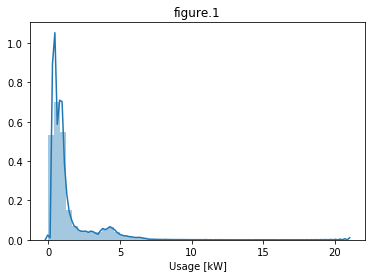

In [321]:
#查看電量大小分布圖
plt.title("figure.1")
sns.distplot(power[target]);


**由此圖可以發現, 大部分的Usage集中在0~2(kW)只有少部分的數據超過5(kW),**
**因此猜測最後近似線也會落在0~2(kW)這個區間內。**

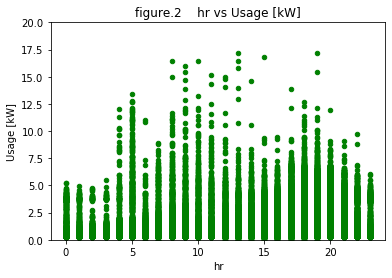

In [322]:
var = 'hr'
data = pd.concat([New_power[target], New_power[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,20),c = 'green');
plt.title("figure.2    hr vs Usage [kW]")
var = 'hr'

**由此圖可以發現4,6,[8到12],18,19為用電量高峰期。**

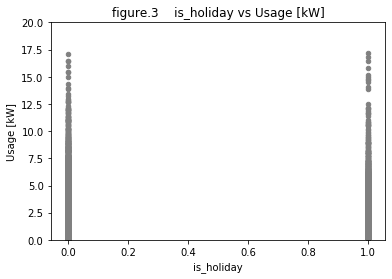

In [323]:
var = 'is_holiday'
data = pd.concat([New_power[target], New_power[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,20),c = 'grey');
plt.title("figure.3    is_holiday vs Usage [kW]")
var = 'is_holiday'

**由此圖可能還是看不出 到底假日用電量跟平日用電量的多寡,只能看出最大值相當,
因此決定各自篩選出來做平均。**

In [324]:
#假日平均用電量
fliter1 = (New_power["is_holiday"] == 1)
X=New_power[fliter1]#篩選出假日的data
x=X['Usage [kW]'].mean()

#平日平均用電量
fliter2 = (New_power["is_holiday"] == 0)
Y=New_power[fliter2]#篩選出假日的data
y=Y['Usage [kW]'].mean()

print('假日平均用電量 : ',x)
print('平日平均用電量 : ',y)

假日平均用電量 :  1.17770993946063
平日平均用電量 :  1.3706771030265223


**可以發現用電量平日較多,假日較少,
因此用電量與平日假日也有關。**

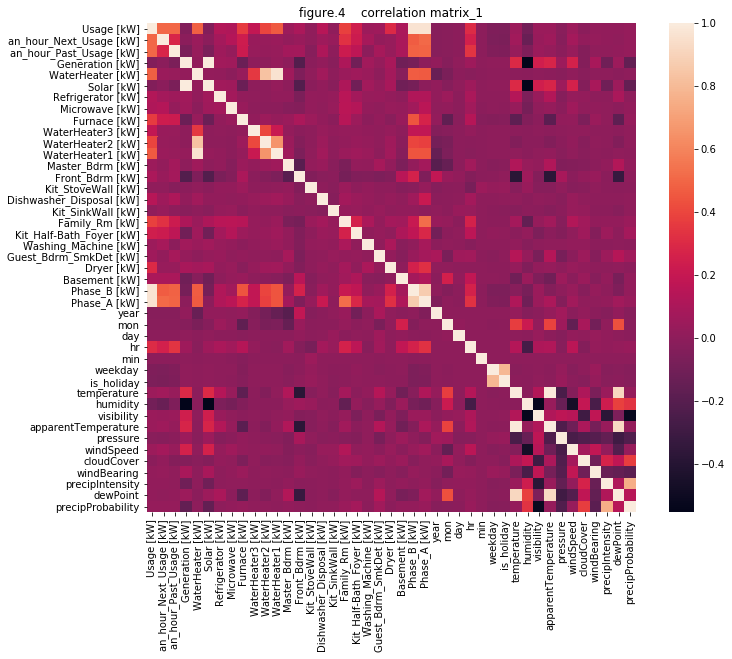

In [325]:
#correlation matrix
corrmat = New_power.corr()
f, ax = plt.subplots(figsize=(12, 9))
plt.title("figure.4    correlation matrix_1")
sns.heatmap(corrmat, vmax=1, square=True);


**此圖為下面那張圖的粗糙版,目的為大致觀察一下各點之間的相關度,
因為只要與電量相關的參數,皆無法提前得知,故不能拿來做預測,
將在下一個步驟簡化。**

In [326]:
New_power=New_power.drop([ 'Generation [kW]', 'WaterHeater [kW]',
       'Solar [kW]', 'Refrigerator [kW]', 'Microwave [kW]', 'Furnace [kW]',
       'WaterHeater3 [kW]', 'WaterHeater2 [kW]', 'WaterHeater1 [kW]',
       'Master_Bdrm [kW]', 'Front_Bdrm [kW]', 'Kit_StoveWall [kW]',
       'Dishwasher_Disposal [kW]', 'Kit_SinkWall [kW]', 'Family_Rm [kW]',
       'Kit_Half-Bath_Foyer [kW]', 'Washing_Machine [kW]',
       'Guest_Bdrm_SmkDet [kW]', 'Dryer [kW]', 'Basement [kW]', 'Phase_B [kW]',
       'Phase_A [kW]'], axis=1)

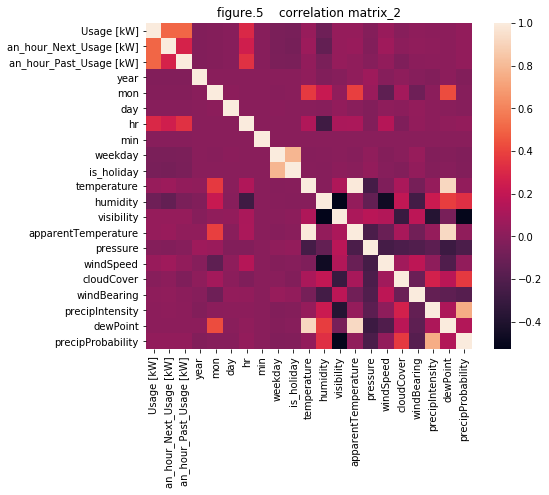

In [327]:
corrmat = New_power.corr()
f, ax = plt.subplots(figsize=(8, 6))
plt.title("figure.5    correlation matrix_2")
sns.heatmap(corrmat, vmax=1, square=True);


**第一階段簡化後的相關性圖示,但還是只能大致上看一下,
下一步驟進一步加強分析。**

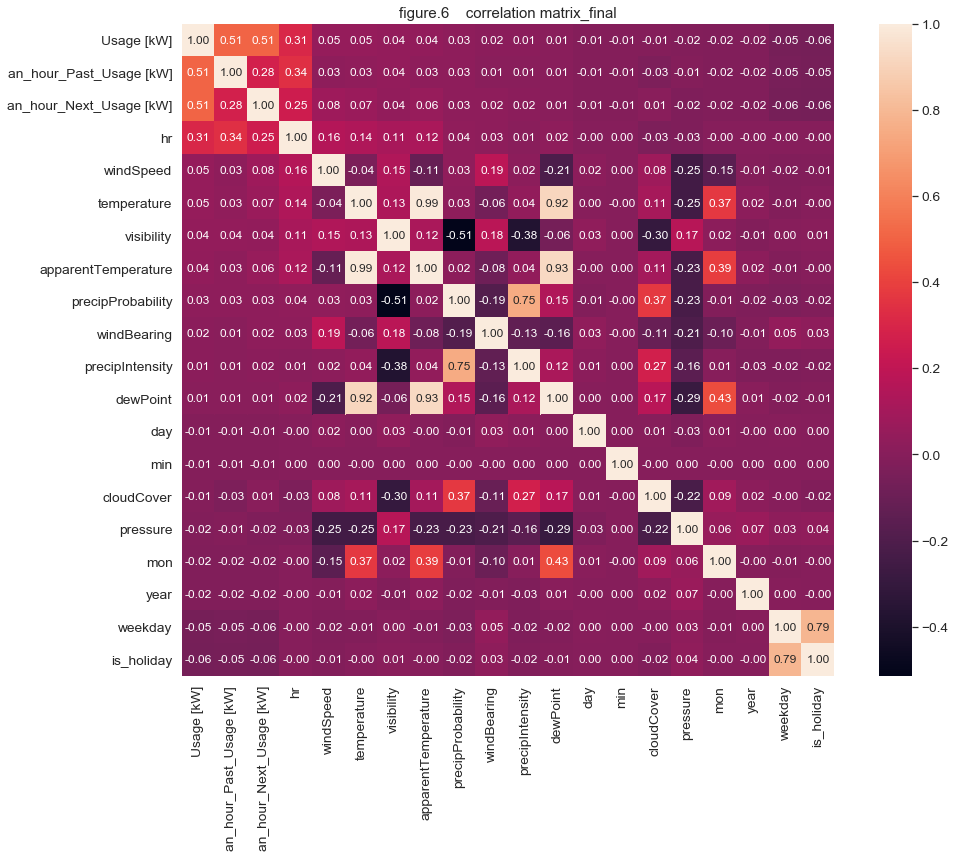

In [355]:
##Usage[kW] correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, target)[target].index
cm = New_power[cols].corr()
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(16,12 ))
hm = sns.heatmap(cm,vmax=1, cbar=True, annot=True, square=True,linewidths=0, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.title("figure.6    correlation matrix_final")
plt.show()


**此圖取出了以Usage為目標,與其相關度高的20名,
可以發現與Usage相關性最大的為hr這個參數,
因此待會將會把hr加入訓練集參數。**

**結論:
由an_hour_Next_Usage可以發現,
一個小時後的電量與"temperature,visibility,apparentTemperature,windSpeed"皆有關,
所以決定再把一個小時前的temperature,visibility,apparentTemperature,windSpeed抓來預測。**

**<font color=black size=6 face=標楷>-----------根據分析結果修改資料建置-----------</font>**

In [349]:
empty = pd.DataFrame(columns=['temperature','visibility','apparentTemperature','windSpeed']) #造一個空的dataframe
X=power[['temperature','visibility','apparentTemperature','windSpeed']]
Past1=X.drop([35040,70073,70074,70075,70076,70077,70078,70079,70080,70081])
Past = pd.concat([empty,Past1],axis=0,ignore_index=True)
Past_t=Past['temperature'].values
Past_v=Past['visibility'].values
Past_a=Past['apparentTemperature'].values
Past_w=Past['windSpeed'].values

In [350]:
#再將Past集合加入dataframe 就成為前一個小時的電量了
New_power=pd.concat([New_power, pd.DataFrame(columns=list(['Past_temperature','Past_visibility','Past_apparentTemperature','Past_windSpeed']))])#將空的一個小時前欄位加入

#將資料加入上述欄位
New_power['Past_temperature']=Past_t
New_power['Past_visibility']=Past_v
New_power['Past_apparentTemperature']=Past_a
New_power['Past_windSpeed']=Past_w

#重新排序欄位
for i in range(0,4):
     last_col = New_power.pop(New_power.columns[-1])
     New_power.insert(2, last_col.name, last_col)

New_power.head()

,Date & Time,Usage [kW],Past_temperature,Past_visibility,Past_apparentTemperature,Past_windSpeed,an_hour_Next_Usage [kW],an_hour_Past_Usage [kW],year,mon,...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,20.85,10.0,8.33,12.83,0.378931,0.977402,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,20.85,10.0,8.33,12.83,0.301320,0.377746,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,20.85,10.0,8.33,12.83,0.280731,0.420196,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,20.85,10.0,8.33,12.83,0.456980,0.290328,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,19.72,10.0,8.49,10.03,0.448540,0.307616,2014.0,1.0,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


**<font color=black size=6 face=標楷>-----------模型建構-----------</font>**

In [351]:
#將資料分成屬性及標籤
X = New_power[['time','an_hour_Past_Usage [kW]','hr', 'is_holiday','Past_temperature','Past_visibility','Past_apparentTemperature']]
Y = New_power['Usage [kW]']

In [352]:
#建立訓練集和測試集

#2014年1月~2015年8月為訓練集,2015年9月~2015年12月為測試集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.167,shuffle=False)
#print('X_train: \n',X_train)
#print('X_test: \n',X_test)
#print('Y_train: \n',Y_train)
#print('Y_test: \n',Y_test)

In [353]:
#建立並訓練模型

regressor = LinearRegression()  
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**<font color=black size=6 face=標楷>-----------預測結果分析-----------</font>**

In [354]:
Y_pred=regressor.predict(X_test)
df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})
df1 = df.head(25) #顯示實際值和預測值
df

,Actual,Predicted
58369,0.395950,0.670297
58370,0.398181,0.628653
58371,0.323748,0.691522
58372,0.415489,0.653919
58373,0.352773,0.689039
...,...,...
70067,1.899674,3.520045
70068,1.795777,3.317286
70069,1.843496,2.138908
70070,1.983620,1.823651


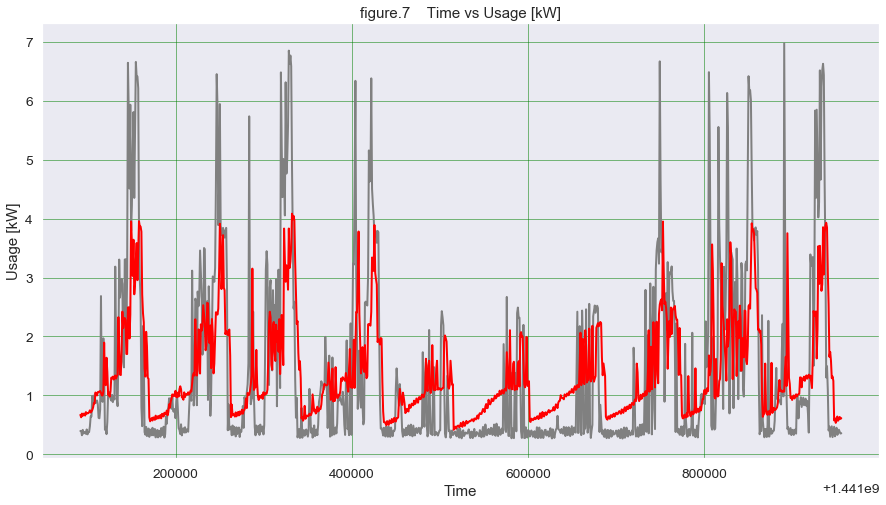

In [335]:
#測試集第一個data 2015-09-01 02:15:00
X_plt=New_power[New_power['Date & Time'].between('2015-09-01 02:15:00','2015-09-11 02:15:00')]
X_plt=X_plt[['time']]


Y_test_plt=Y_test.iloc[0:961]
Y_pred_plt=Y_pred[0:961]


plt.figure(figsize=(15,8),frameon=True) #整个现实图（框架）的大小
plt.plot(X_plt,Y_test_plt,color='gray',linewidth=2)
plt.plot(X_plt,Y_pred_plt,color='red',linewidth=2)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.xlabel('Time')
plt.ylabel("Usage [kW]")
plt.title("figure.7    Time vs Usage [kW]")
plt.show()

 
#視覺化


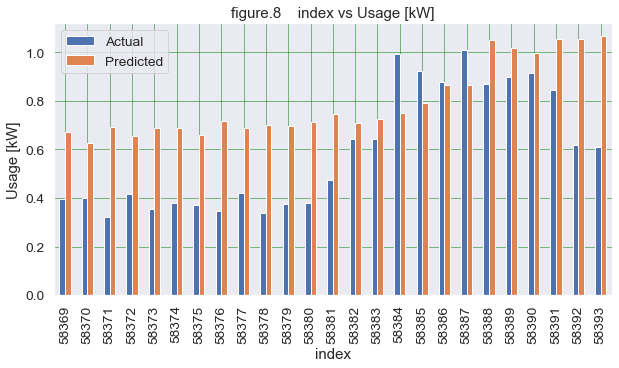

In [336]:
print(' ')
print('#視覺化')
df1.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('index')
plt.ylabel("Usage [kW]")
plt.title("figure.8    index vs Usage [kW]")
plt.show()

**由上面兩張圖,可以看到大致上的結果趨勢線,可以看到峰值的時候預測比較準確,
接下來我會針對峰值的部分放大分析。**

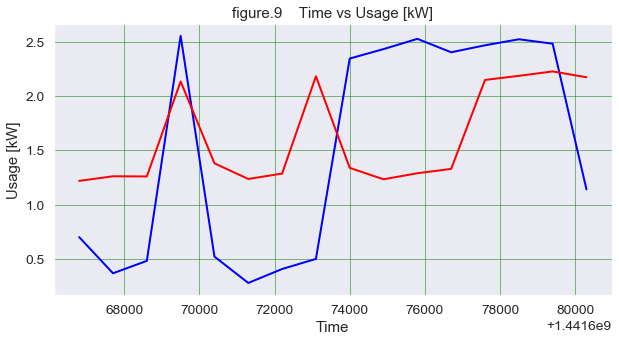

In [337]:
#取2015-09-7 18:00:00'到'2015-09-7 21:45:00的data

X_plt=New_power[New_power['Date & Time'].between('2015-09-01 02:15:00','2015-09-11 02:15:00')]
X_plt=X_plt[X_plt['day'].between(7,7)]
X_plt=X_plt[X_plt['hr'].between(18,21)]
X_plt=X_plt[['time']]


Y_test_plt=Y_test.iloc[639:655]
Y_pred_plt=Y_pred[639:655]


plt.figure(figsize=(10,5),frameon=True) #整个现实图（框架）的大小
plt.plot(X_plt,Y_test_plt,color='blue',linewidth=2)
plt.plot(X_plt,Y_pred_plt,color='red',linewidth=2)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.xlabel('Time')
plt.ylabel("Usage [kW]")
plt.title("figure.9    Time vs Usage [kW]")
plt.show()


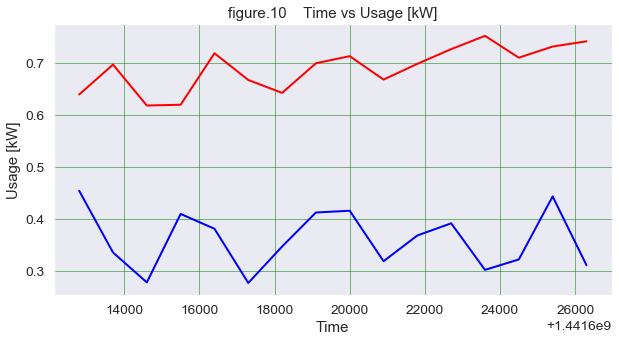

In [338]:
#取2015-09-10 18:00:00'到'2015-09-10 21:45:00的data

X_plt=New_power[New_power['Date & Time'].between('2015-09-01 02:15:00','2015-09-11 02:15:00')]
X_plt=X_plt[X_plt['day'].between(7,7)]
X_plt=X_plt[X_plt['hr'].between(3,6)]
X_plt=X_plt[['time']]


Y_test_plt=Y_test.iloc[579:595]
Y_pred_plt=Y_pred[579:595]


plt.figure(figsize=(10,5),frameon=True) #整个现实图（框架）的大小
plt.plot(X_plt,Y_test_plt,color='blue',linewidth=2)
plt.plot(X_plt,Y_pred_plt,color='red',linewidth=2)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.xlabel('Time')
plt.ylabel("Usage [kW]")
plt.title("figure.10    Time vs Usage [kW]")
plt.show()


**由上面兩個圖比較可以看到確實在峰值時預測成功率較高,主要是演算法在像峰值這種特殊的值的時候,會更好辨識與學習,使得其很好辨識甚麼時候會到達峰值,因此預測成功率會較高。**

In [339]:
#平均絕對誤差(MAE)、均方誤差(MSE)、均方根誤差(RMSE)
print('*Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print(' ')  
print('檢查準確度(%): ',regressor.score(X_train, Y_train)*100)

*Mean Absolute Error: 0.6238163316321663
Mean Squared Error: 0.9637901435911188
Root Mean Squared Error: 0.9817281413869722
 
檢查準確度(%):  26.03863157586708


**就分析結果來說,還有很大的進步空間,未來可以嘗試用2個小時以前或是3個小時以前的數據來進行預測,
來增加預測成功率以及MAE。**

**<font color=black size=6 face=標楷>-----------未來預測-----------</font>**

In [340]:
#假設為2015年12月31號22:45分的下一個小時=2015年12月31號23:45分溫度為20度
data = {'time':[1451619900],'an_hour_Past_Usage [kW]':[1.899674],'hr':[23],
       'is_holiday':[0],'Past_temperature':[37.30],'Past_visibility':[10],'Past_apparentTemperature':[29.58]}
next_hours_data = pd.DataFrame(data)
next_hours_data



,time,an_hour_Past_Usage [kW],hr,is_holiday,Past_temperature,Past_visibility,Past_apparentTemperature
0,1451619900,1.899674,23,0,37.3,10,29.58


In [341]:
#預測下一個小時用電量
next_hours=regressor.predict(next_hours_data)
print('下一小時的電量: ',next_hours)


下一小時的電量:  [1.93797784]


In [ ]:
#假設用一個小時之前的time,Usage [kW],temperature,visibility,apparentTemperature以及hr,holiday的dataset,
#此dataset之輸出結果為我們的目標

pw2016=pd.read_csv('xxx')#xxx為檔案路徑名稱

In [ ]:
#以時間,溫度,小時為特徵來預測用電量
Z = power2016[['time','an_hour_Past_Usage [kW]','hr', 'is_holiday','Past_temperature','Past_visibility','Past_apparentTemperature']]
Z_pred=regressor.predict(Z)#預測結果
df = pd.DataFrame({ 'Predicted': Z_pred})
df1 = df.head(25) 
df